# Testing the exchange formulas from Burkard et al. (1999) paper

## 0. Importing modules

In [1]:
import math
import numpy as np
import sympy as sp
from scipy import special

import matplotlib.pyplot as plt


## 1. Defining the system parameters

All units are SI.



In [2]:
####### Constant parameters ########

hbar = 1.0546e-34

# for Si
#kappa = (11.7 + 3.7)/2
#m = 0.191 * 9.1e-31

# for GaAs
kappa = 13.1
m = 0.067 * 9.1e-31

e = 1.60217662e-19
epsilon_0 = 8.854e-12

###### Variable parameters as lambdas for convenient plotting

omega_0_ = lambda a_B: hbar / (m * a_B**2)
omega_L_ = lambda B: e * B / (2 * m)
c_ = lambda a_B: (math.sqrt(math.pi / 2) * e**2 / 
                  (4 * math.pi * epsilon_0 * kappa * a_B) / (hbar * omega_0_(a_B)))
b_ = lambda omega_0, B: math.sqrt(1 + omega_L_(B)**2 / omega_0_(a_B)**2)
d_ = lambda a, a_B: a / a_B
S_ = lambda d, b: math.exp( d**2 * (1 / b - 2 * b))

g_ = lambda d, b: (1 - math.sqrt(1 - S_(d, b)**2)) / S_(d, b)
N_ = lambda d, b: 1 / math.sqrt(1 - 2 * S_(d, b) * g_(d, b) + g_(d, b)**2)

## 2. Defining the Hund-Mulliken parameters

In [3]:
epsilon_ = lambda d, b, S: (3 / (32 * b**2 * d**2) + 
                            3 / 8 * S**2 / (1 - S**2) * (1 / b + d**2) + b)
t_ = lambda d, b, S: 3 / 8 * S / (1 - S**2) * (1 / b + d**2)

F_1_ = lambda c, b: c * math.sqrt(b)
F_2_ = lambda c, d, b: c * math.sqrt(b) * math.exp(- b * d**2) * special.iv(0, b * d**2)
F_3_ = lambda c, d, b: c * math.sqrt(b) * math.exp(d**2 * (b - 1 / b)) * special.iv(0, d**2 * (b - 1 / b))
F_4_ = lambda c, d, b: (c * math.sqrt(b) * math.exp(- d**2 / (4 * b)) *
                           sum([ (-1)**k * special.iv(2 * k, (d**2 * ( 2 * b - 1 / b) / 4)) * 
                                special.iv(2*k, 1j * d**2 / 2 * math.sqrt(b**2 - 1))
                                for k in (-1,0,1)]))

def CMEs(c, d, b):
    # returns the tuple of Coulomb matrix elements
    S, g, N, F_1, F_2, F_3, F_4 = (S_(d, b), g_(d, b), N_(d, b), 
                                  F_1_(c, b), F_2_(c, d, b), F_3_(c, d, b), F_4_(c, d, b))
    
    V_plus = N**4 * (4 * g**2 * (1 + S**2) * F_1 + (1 + g**2) **2 * F_2 
                     + 4 * g**2 * F_3 - 16 * g**2 * F_4)
    
    V_minus = N**4 * (1 - g**2)**2 * (F_2 - S**2 * F_3)
    
    U = N**4 * ((1 + g**4 + 2 * g**2 * S**2) * F_1 + 2 * g**2 * F_2 + 
                2 * g**2 * S**2 * F_3 - 8 * g **2 * F_4)
    
    X = N**4 * (((1 + g**4) * S**2+ 2 * g**2 ) * F_1 + 2 * g**2 * F_2 + 
                2 * g**2 * S**2 * F_3 - 8 * g **2 * F_4)
     
    w = N**4 * (-g * (1 + g**2) *(1 + S**2) * F_1 - g * (1 + g**2) * F_2 
               -g * (1 + g**2) * S**2 * F_3 + (1 + 6 * g**2 + g**4) * S * F_4)

    return (V_plus, V_minus, U, X, w)
 

## 3. Finding the HM eigenvalues

In [4]:
# one of the parameters is a functor
# (for the convenient choice of biquadratic or quartic potential)

def J_HM(a_B, a, B):
    omega_0, omega_L, c = omega_0_(a_B), omega_L_(B), c_(a_B)
    b, d = b_(omega_0, B), d_(a, a_B)
    epsilon, t = epsilon_(d, b, S_(d, b)), t_(d, b, S_(d, b))
    V_plus, V_minus, U, X, w = CMEs(c, d, b)
    
    t_H = t - w
    V = V_minus - V_plus
    U_H = U - V_plus + X
    
    J = V - U_H / 2 + 1 / 2 * (U_H**2 + 16 * t_H**2)**0.5    
    return J

def J_HL(a_B, a, B):
    omega_0, omega_L, c = omega_0_(a_B), omega_L_(B), c_(a_B)
    b, d = b_(omega_0, B), d_(a, a_B)
    Jhl = (hbar * omega_0 / math.sinh(2 * d**2 *(2 * b - 1 / b))) * (c * math.sqrt(b) * 
            (math.exp(-b * d**2) * special.iv(0, (b * d**2)) 
                     - math.exp(d**2 * (b - 1 / b))* special.iv(0, (d**2 * (b - 1 / b))))
                                                    + 3 / (4 * b) * (1 + b * d**2))
    return Jhl

## 4. Testing

### (a) Dependency on interdot distance

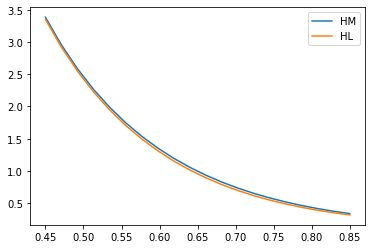

In [5]:
c = 2.4

#I know, it would be more logical to make 
a_B = c / (math.sqrt( math.pi /2 ) * e**2 *m / (4 *math.pi * epsilon_0 * kappa * hbar**2))

d_s = np.linspace(0.45,0.85,20)
a_s = d_s * a_B
B = 0

#print(*[CMEs(c, d, 1) for d  in d_s])
#print(a_)

J_HM_arr = np.real(np.array([J_HM(a_B, a, B) * hbar * omega_0_(a_B)/1.6e-22 for a in a_s]))
J_HL_arr = np.real(np.array([J_HL(a_B, a, B) / 1.6e-22 for a in a_s]))
plt.plot(d_s, J_HM_arr, label="HM")
plt.plot(d_s,J_HL_arr, label="HL")

#plt.yscale("log")
plt.legend(loc='upper right')

plt.show()


### (b) Dependence on magnetic field 

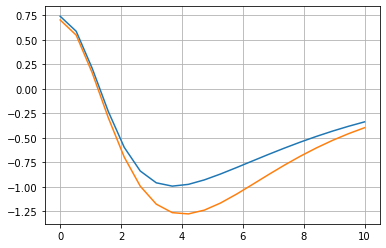

In [6]:
B_s = np.linspace(0,10,20)

J_HM_arr = np.real(np.array([J_HM(a_B, 0.7 *a_B, b) * hbar * omega_0_(a_B)/1.6e-22 for b in B_s]))
J_HL_arr = np.real(np.array([J_HL(a_B, 0.7 *a_B, b) / 1.6e-22 for b in B_s]))

plt.plot(B_s, J_HM_arr, label="HM")
plt.plot(B_s,J_HL_arr, label="HL")
plt.grid( True)
plt.rc('grid', linestyle="--", color='grey')
plt.show()